**_PROJECT-2 Маляренко Алексей DAPR-17_** 01.03.2021

### Описание гипотезы

Проверим два предположения:

1. Отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение? Насколько обучение сокращает время прохождения этапов?

2. Существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь?

А Также  вопрос:
Как часто пользователи начинают обучение после того, как они выбрали уровень сложности?

Проверку будем производить на основе данных пользователей, которые зарегистрировались в 2018 году.

### Ход проверки

#### Импорт библиотек, загрузка данных, получение данных от 2018 года

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [ ]:
# скачать анализируемые данные можно по приведённой ниже ссылкам
# действие и время пользователя
events_df = pd.read_csv('7_4_Events.csv') #https://drive.google.com/file/d/127rRKPGljuZh3ARfl6xWDCNF4FLljlDV/view?usp=sharing 7_4_Events.csv
# действие покупки пользователей 
purchase_df = pd.read_csv('7_4_Purchase.csv') #https://drive.google.com/file/d/1tRn650bJ4hSEkoZfA0YDMDSl3LjaqpGz/view?usp=sharing 7_4_Purchase.csv

##### Смена формата даты

In [ ]:
# пред обработка events_df
events_df['year'] = pd.to_numeric(events_df['start_time'].str[:4]) 
id_2018 = events_df['user_id'][(events_df['year'] == 2018)&(events_df['event_type'] == 'registration')]
events_df = events_df.drop('year', 1)
id_2018_list = id_2018.to_list()
events_df = events_df[events_df['user_id'].isin(id_2018_list)]
events_df = events_df.rename(columns={'id':'event_id'})
events_df['start_time'] = pd.to_datetime(events_df['start_time'],format='%Y-%m-%dT%H:%M:%S') # дата в правильном виде

In [ ]:
# пред обработка purchase_df
purchase_df = purchase_df[purchase_df['user_id'].isin(id_2018_list)]
purchase_df = purchase_df.rename(columns={'id':'purchase_id'})
purchase_df['event_type'] = 'purchase'
purchase_df['event_datetime'] = pd.to_datetime(purchase_df['event_datetime'],format='%Y-%m-%dT%H:%M:%S') # дата в правильном виде

In [ ]:
# таблица с объединёнными входными таблицами
total_events_df = pd.concat([events_df,purchase_df],sort=False)
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

### Основные таблицы используемые в работе

In [ ]:
total_events_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,event_datetime,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaT,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaT,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaT,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaT,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...
68554,NaN,purchase,NaN,NaT,NaN,47498,18441.0,2019-01-02 03:48:19,100.0
68555,NaN,purchase,NaN,NaT,NaN,47647,18442.0,2019-01-02 23:26:26,150.0
68556,NaN,purchase,NaN,NaT,NaN,47554,18443.0,2019-01-03 00:36:36,50.0
68557,NaN,purchase,NaN,NaT,NaN,47742,18448.0,2019-01-04 12:51:41,50.0


In [ ]:
events_df

,event_id,event_type,selected_level,start_time,tutorial_id,user_id
51405,80308,registration,NaN,2018-01-01 03:48:40,NaN,27832
51406,80309,registration,NaN,2018-01-01 04:07:25,NaN,27833
51407,80310,registration,NaN,2018-01-01 08:35:10,NaN,27834
51408,80311,registration,NaN,2018-01-01 11:54:47,NaN,27835
51409,80312,registration,NaN,2018-01-01 13:28:07,NaN,27836
...,...,...,...,...,...,...
118359,147262,tutorial_start,NaN,2019-01-01 03:26:18,49554.0,47756
118360,147263,tutorial_finish,NaN,2019-01-01 03:29:25,49554.0,47756
118362,147265,level_choice,easy,2019-01-01 05:04:52,NaN,47755
118363,147266,level_choice,medium,2019-01-01 05:42:11,NaN,47756


In [ ]:
purchase_df

,purchase_id,user_id,event_datetime,amount,event_type
1171,16845,27845,2018-01-03 18:53:43,100,purchase
1172,16846,27865,2018-01-04 14:46:10,250,purchase
1174,16848,27911,2018-01-07 08:19:12,50,purchase
1175,16849,27910,2018-01-07 12:11:34,100,purchase
1176,16850,27940,2018-01-07 13:16:41,200,purchase
...,...,...,...,...,...
2767,18441,47498,2019-01-02 03:48:19,100,purchase
2768,18442,47647,2019-01-02 23:26:26,150,purchase
2769,18443,47554,2019-01-03 00:36:36,50,purchase
2774,18448,47742,2019-01-04 12:51:41,50,purchase


#### Проверка для понимания свойств таблиц

In [ ]:
# проверяю не пропущены ли где значения
events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  int64         
 1   event_type      66959 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      66959 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         66959 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.6+ MB


In [ ]:
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1171 to 2778
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   purchase_id     1600 non-null   int64         
 1   user_id         1600 non-null   int64         
 2   event_datetime  1600 non-null   datetime64[ns]
 3   amount          1600 non-null   int64         
 4   event_type      1600 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 75.0+ KB


In [ ]:
# суммы совпадают
total_events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68559 entries, 0 to 68558
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   event_id        66959 non-null  float64       
 1   event_type      68559 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      66959 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         68559 non-null  int64         
 6   purchase_id     1600 non-null   float64       
 7   event_datetime  1600 non-null   datetime64[ns]
 8   amount          1600 non-null   float64       
dtypes: datetime64[ns](2), float64(4), int64(1), object(2)
memory usage: 5.2+ MB


In [ ]:
# просмотр сум всех действий
events_df['event_type'].value_counts()

registration       19926
tutorial_start     18050
tutorial_finish    14904
level_choice        8342
pack_choice         5737
Name: event_type, dtype: int64

In [ ]:
# тут проверяться и объявляться переменные для облегчения ориентирования по переменным
registration_df = events_df[events_df['event_type'] == 'registration']
print(registration_df['user_id'].value_counts().mean())
tutorial_start_df = events_df[events_df['event_type']=='tutorial_start']
print(tutorial_start_df['user_id'].value_counts().mean())
tutorial_finish_df = events_df[events_df['event_type']=='tutorial_finish']
print(tutorial_finish_df['user_id'].value_counts().mean())
level_choice_df = events_df[events_df['event_type']=='level_choice']
print(level_choice_df['user_id'].value_counts().mean())
pack_choice_df = events_df[events_df['event_type']=='pack_choice']
print(pack_choice_df['user_id'].value_counts().mean())
print(purchase_df['user_id'].value_counts().mean())

1.0
1.522179119581717
1.4540487804878048
1.0
1.0
1.0


In [ ]:
# изменения для удобства в анализе
tutorial_start_df = tutorial_start_df.drop_duplicates('user_id')
print(tutorial_start_df['user_id'].value_counts().mean())
tutorial_finish_df = tutorial_finish_df.drop_duplicates('user_id')
print(tutorial_finish_df['user_id'].value_counts().mean())

1.0
1.0


### Отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение

#### Деление

In [ ]:
tutorial_start_user_id_set = set(tutorial_start_df['user_id'])
user_id_events_set = set(events_df['user_id'])
# выделил пользователей ни разу не начавших обучение 
tutorial_not_start_user_id_set = user_id_events_set.difference(tutorial_start_user_id_set)

# пользователи завершившие туториал
tutorial_finish_total_events_df = total_events_df[total_events_df['user_id'].isin(tutorial_finish_df['user_id'])]
# пользователи не начавшие обучение
tutorial_not_start_total_events_df = total_events_df[total_events_df['user_id'].isin(tutorial_not_start_user_id_set)]

In [ ]:
# сводные таблицы для пользователей двух групп
tutorial_finish_pt = tutorial_finish_total_events_df.pivot_table(values=['start_time'], index=['user_id'], columns=['event_type'], aggfunc='min')
tutorial_not_start_pt = tutorial_not_start_total_events_df.pivot_table(values=['start_time'], index=['user_id'], columns=['event_type'], aggfunc='min')
# делаем обращение удобней
tutorial_finish_pt.columns = [tup[1] if tup[1] else tup[0] for tup in tutorial_finish_pt.columns]
tutorial_not_start_pt.columns = [tup[1] if tup[1] else tup[0] for tup in tutorial_not_start_pt.columns]

In [ ]:
# удобно фильтруем сеты
# прошедшие обучение 
tutorial_start_f = tutorial_finish_pt.merge(tutorial_start_df['user_id'],on='user_id',how='inner')
pack_choice_f = tutorial_finish_pt.merge(pack_choice_df['user_id'],on='user_id',how='inner')
purchase_f = tutorial_finish_pt.merge(purchase_df[['user_id','event_datetime']],on='user_id',how='inner')
# не начали
not_level_choice_f = tutorial_not_start_pt.merge(level_choice_df['user_id'],on='user_id',how='inner')
not_pack_choice_f = tutorial_not_start_pt.merge(pack_choice_df['user_id'],on='user_id',how='inner')
not_purchase_f = tutorial_not_start_pt.merge(purchase_df[['user_id','event_datetime']],on='user_id',how='inner')

#### Код для проверки первой гипотезы

In [ ]:
# ищем timedelta
# прошедшие обучение
tutorial_start_f['timedelta'] = tutorial_start_f['tutorial_start'] - tutorial_start_f['registration']
pack_choice_f['timedelta'] = pack_choice_f['pack_choice'] - pack_choice_f['level_choice']
purchase_f['timedelta'] = purchase_f['event_datetime'] - purchase_f['pack_choice']
purchase_f['r_p'] = purchase_f['event_datetime'] - purchase_f['registration']
# не начали
not_level_choice_f['timedelta'] = not_level_choice_f['level_choice'] - not_level_choice_f['registration']
not_pack_choice_f['timedelta'] = not_pack_choice_f['pack_choice'] - not_pack_choice_f['level_choice']
not_purchase_f['timedelta'] = not_purchase_f['event_datetime'] - not_purchase_f['pack_choice']
not_purchase_f['r_p'] = not_purchase_f['event_datetime'] - not_purchase_f['registration']

# вывод данных
# прошедшие обучение
r_t = tutorial_start_f['timedelta'].mean()
r_p = pack_choice_f['timedelta'].mean()
r_pu = purchase_f['timedelta'].mean()
r_r = purchase_f['r_p'].mean()
# не начали
not_r_l = not_level_choice_f['timedelta'].mean()
not_r_p = not_pack_choice_f['timedelta'].mean()
not_r_pu = not_purchase_f['timedelta'].mean()
not_r_r = not_purchase_f['r_p'].mean()


In [ ]:
# получаю два словаря
hg = {'Прошедшие обучение':{'Регистрация-(обучениe-выбор cлож.)':r_t,'выбор сложности-пак вопросов':r_p,'выбор пака вопросов-покупка':r_pu},
      'Не начали обучение':{'Регистрация-(обучениe-выбор cлож.)':not_r_l,'выбор сложности-пак вопросов':not_r_p,'выбор пака вопросов-покупка':not_r_pu}}
hk = {'Прошедшие обучение':{'Регистрация-покупка':r_r},
      'Не начали обучение':{'Регистрация-покупка':not_r_r}}

In [ ]:
# преобразую словари в датафреймы
hg_df = pd.DataFrame(data=hg)
hk_df = pd.DataFrame(data=hk)

In [ ]:
# редактирую датафреймы для тадлиц
hg_df.loc['Регистрация-(обучениe-выбор cлож.)'] = hg_df.loc['Регистрация-(обучениe-выбор cлож.)'].apply(lambda x: round(x.total_seconds()/60,0))
hg_df.loc['выбор сложности-пак вопросов'] = hg_df.loc['выбор сложности-пак вопросов'].apply(lambda x: round(x.total_seconds()/1,0))
hg_df.loc['выбор пака вопросов-покупка'] = hg_df.loc['выбор пака вопросов-покупка'].apply(lambda x: round(x.total_seconds()/3600,0))
hk_df.loc['Регистрация-покупка'] = hk_df.loc['Регистрация-покупка'].apply(lambda x: round(x.total_seconds()/3600,0))

In [ ]:
# добавляю разницу
hg_df['Разниц 1 и 2 показателей'] = hg_df['Не начали обучение'] - hg_df['Прошедшие обучение']
hg_df['Разниц 1 и 2 показателей'] = hg_df['Разниц 1 и 2 показателей'].apply(lambda x: round(x,0))
hk_df['Разниц 1 и 2 показателей'] = hk_df['Не начали обучение'] - hk_df['Прошедшие обучение']
hk_df['Разниц 1 и 2 показателей'] = hk_df['Разниц 1 и 2 показателей'].apply(lambda x: round(x,0))

#### Числовые выводы по 1 гипотезе

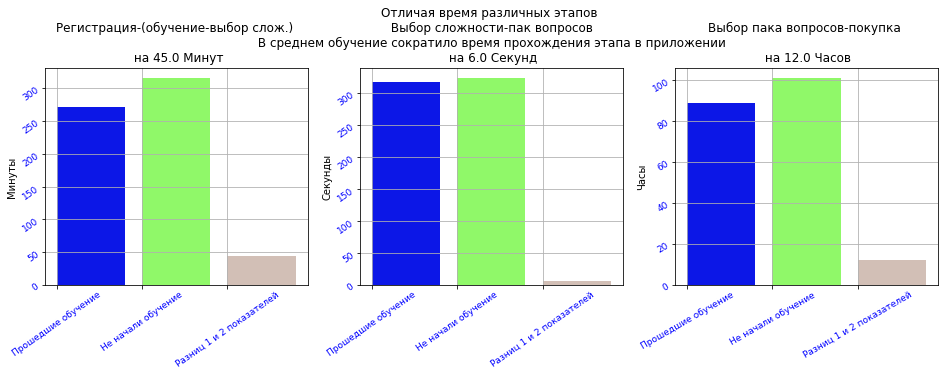

In [ ]:
# тройной график
fig, axes = plt.subplots(1, 3, figsize=(16,4))
# цвета и структура первого грфика
axes[0].bar(x = hg_df.T.index, height=hg_df.T['Регистрация-(обучениe-выбор cлож.)'],
            align = 'edge',color=[[0.04794151, 0.08893703, 0.90630365],[0.56296929, 0.97291764, 0.41094361],[0.82394557, 0.75060714, 0.71378445]])
# остальные элементы
axes[0].set_title('Регистрация-(обучениe-выбор cлож.) \n \n на {} Минут'.format(hg_df.iloc[0][2])) 
axes[0].grid(True) # сетка
axes[0].set_ylabel('Минуты') # у подпись
axes[0].tick_params(pad = 1,    #  Расстояние между черточкой и ее подписью
               labelsize = 9,    #  Размер подписи
               labelcolor = 'b',    #  Цвет подписи
               labelrotation = 35)    #  Поворот подписей

axes[1].bar(x = hg_df.T.index, height=hg_df.T['выбор сложности-пак вопросов'],
            align='edge',color=[[0.04794151, 0.08893703, 0.90630365],[0.56296929, 0.97291764, 0.41094361],[0.82394557, 0.75060714, 0.71378445]])
axes[1].set_title('Отличая время различных этапов \n Выбор сложности-пак вопросов \n В среднем обучение сократило время прохождения этапа в приложении \n на {} Секунд'.format(hg_df.iloc[1][2]))
axes[1].grid(True)
axes[1].set_ylabel('Секунды')
axes[1].tick_params(pad = 1,    
               labelsize = 9,   
               labelcolor = 'b',  
               labelrotation = 35)   

axes[2].bar(x = hg_df.T.index, height=hg_df.T['выбор пака вопросов-покупка'],
            align='edge',color=[[0.04794151, 0.08893703, 0.90630365],[0.56296929, 0.97291764, 0.41094361],[0.82394557, 0.75060714, 0.71378445]])
axes[2].set_title('Выбор пака вопросов-покупка \n \n на {} Часов'.format(hg_df.iloc[2][2]))
axes[2].grid(True)
axes[2].set_ylabel('Часы')
axes[2].tick_params(pad = 1,  
               labelsize = 9,  
               labelcolor = 'b',  
               labelrotation = 30) 


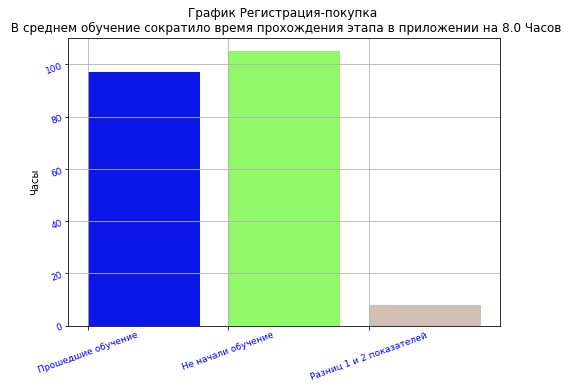

In [ ]:
# график обобщение временные данные
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x = hk_df.T.index, height=hk_df.T['Регистрация-покупка'],
            align = 'edge',color=[[0.04794151, 0.08893703, 0.90630365],[0.56296929, 0.97291764, 0.41094361],[0.82394557, 0.75060714, 0.71378445]])
axes.set_title('График Регистрация-покупка \n В среднем обучение сократило время прохождения этапа в приложении на {} Часов'.format(hk_df.iloc[0][2]))
axes.grid(True)
axes.set_ylabel('Часы')
axes.tick_params(pad = 1,    
               labelsize = 9,   
               labelcolor = 'b',  
               labelrotation = 20)   


In [ ]:
# вывод данных
print('{} Регистрация-наячало обучения (прошедшие обучение)'.format(r_t))
print('{} Регистрация-выбор сложности (не начали обучение)'.format(not_r_l))
print()
print('{} выбор сложности-пак вопросов (прошедшие обучение)'.format(r_p))
print('{} выбор сложности-пак вопросов (не начали обучение)'.format(not_r_p))
print()
print('{} выбор пака вопросов-покупка (прошедшие обучение)'.format(r_pu))
print('{} выбор пака вопросов-покупка (не начали обучение)'.format(not_r_pu))
print()
print('{} Регистрация-покупка (прошедшие обучение)'.format(r_r))
print('{} Регистрация-покупка (не начали обучение)'.format(not_r_r))

0 days 04:31:04.938146341 Регистрация-наячало обучения (прошедшие обучение)
0 days 05:15:33.122448979 Регистрация-выбор сложности (не начали обучение)

0 days 00:05:18.146058732 выбор сложности-пак вопросов (прошедшие обучение)
0 days 00:05:23.824324324 выбор сложности-пак вопросов (не начали обучение)

3 days 17:17:59.641326883 выбор пака вопросов-покупка (прошедшие обучение)
4 days 04:49:33.590909090 выбор пака вопросов-покупка (не начали обучение)

4 days 00:30:03.247408431 Регистрация-покупка (прошедшие обучение)
4 days 09:06:01.909090909 Регистрация-покупка (не начали обучение)


### Вывод по первой гипотезе 

Как видно из выше приведённых графиков, обучение, как правило, сокращает время для прохождения этапов. Выше приведено в графическом виде общее время от регистрации до покупки (усреднённое). Как можно видеть, весь путь пользователя в усреднённом варианте сократился на 8 часов, что хорошо тем, что клиент начнёт окупать потраченные на поддержку приложения средства раньше. В этапы ускорились на:

Регистрация-(обучениe-выбор cлож.) - 45 минут

Выбор сложности-пак вопросов - 6 секунд

Выбор пака вопросов-покупка - 12 часов

Регистрация-покупка - 8 часов

Значит, можно смело утверждать, что гипотеза полностью верна, и сделать обучение более привлекательным к прохождению. Можно поднять награду или предложить "сюрприз коробку" со случайным призом по окончанию прохождения.

### Существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь

#### Деление

In [ ]:
# берём данные
tutorial_start_df = events_df[events_df['event_type']=='tutorial_start']
print(tutorial_start_df['user_id'].value_counts().mean())
tutorial_finish_df = events_df[events_df['event_type']=='tutorial_finish']
print(tutorial_finish_df['user_id'].value_counts().mean())

1.522179119581717
1.4540487804878048


#### Код для проверки второй гипотезы

In [ ]:
# подготовка с переименованием
tutorial_start = tutorial_start_df['user_id'].value_counts().reset_index()
tutorial_finish = tutorial_finish_df['user_id'].value_counts().reset_index()

tutorial_start = tutorial_start.rename(columns={'index':'user_id','user_id':'count'})
tutorial_finish = tutorial_finish.rename(columns={'index':'user_id','user_id':'count'})
# пробная проверка 
#print(tutorial_start['count'].value_counts())
#print(tutorial_finish['count'].value_counts())

# пользователи не начавшие обучение
tutorial_not_start_total_events_df 

# подсчёт процента
def user_id_set(x,y): 
    user_co = x[x['count']==y]
    lne_x = len(user_co)
    lne_pu = len(user_co.merge(purchase_df['user_id'],on='user_id',how='inner'))
    pro = lne_pu/lne_x
    return pro
    
# вывод для второго вопроса 
def resolt(x):
    l = len(tutorial_start)
    for i in range(1,len(tutorial_start['count'].unique())+1):
        if len(x) == l:
            print('Процент оплативших пользователей, начавших обучение {}р. {:.2%}'.format(i,user_id_set(x,i)))
        else:
            print('Процент оплативших пользователей, закончивших обучение {}р. {:.2%}'.format(i,user_id_set(x,i)))
            
# получение дата фрейма для столбчатой диаграммы
def table(g,j):
    di = dict()
    li1 = []
    li2 = []
    for i in range(1,len(tutorial_start['count'].unique())+1):
        li1.append(user_id_set(g,i))
        li2.append(user_id_set(j,i))
    di['начавших обучение'] = li1
    di['закончивших обучение'] = li2
    return di
# процент оплативших из тех пользователей кто не начал обучение
not_user_id_un = tutorial_not_start_total_events_df['user_id'].nunique()

not_user_id_un_purchase = tutorial_not_start_total_events_df.merge(purchase_df['user_id'],on='user_id',how='inner')['user_id'].nunique()

#### Числовые выводы по 2 гипотезе

In [ ]:
print('Процент оплативших пользователей, не начавших обучение {:.2%}'.format(not_user_id_un_purchase/not_user_id_un))
print()
resolt(tutorial_start)

Процент оплативших пользователей, не начавших обучение 0.27%

Процент оплативших пользователей, начавших обучение 1р. 13.26%
Процент оплативших пользователей, начавших обучение 2р. 13.72%
Процент оплативших пользователей, начавших обучение 3р. 11.94%
Процент оплативших пользователей, начавших обучение 4р. 13.57%
Процент оплативших пользователей, начавших обучение 5р. 14.68%
Процент оплативших пользователей, начавших обучение 6р. 12.07%
Процент оплативших пользователей, начавших обучение 7р. 12.77%
Процент оплативших пользователей, начавших обучение 8р. 15.12%
Процент оплативших пользователей, начавших обучение 9р. 15.04%


In [ ]:
resolt(tutorial_finish)

Процент оплативших пользователей, закончивших обучение 1р. 14.26%
Процент оплативших пользователей, закончивших обучение 2р. 13.78%
Процент оплативших пользователей, закончивших обучение 3р. 12.75%
Процент оплативших пользователей, закончивших обучение 4р. 10.67%
Процент оплативших пользователей, закончивших обучение 5р. 16.24%
Процент оплативших пользователей, закончивших обучение 6р. 14.85%
Процент оплативших пользователей, закончивших обучение 7р. 15.46%
Процент оплативших пользователей, закончивших обучение 8р. 11.11%
Процент оплативших пользователей, закончивших обучение 9р. 18.18%


In [ ]:
# датафрейм под график
gr_tutorial_df = pd.DataFrame(data=table(tutorial_start,tutorial_finish),index=[1,2,3,4,5,6,7,8,9])

Text(0.5, 0, 'Количество прохождений обучения')

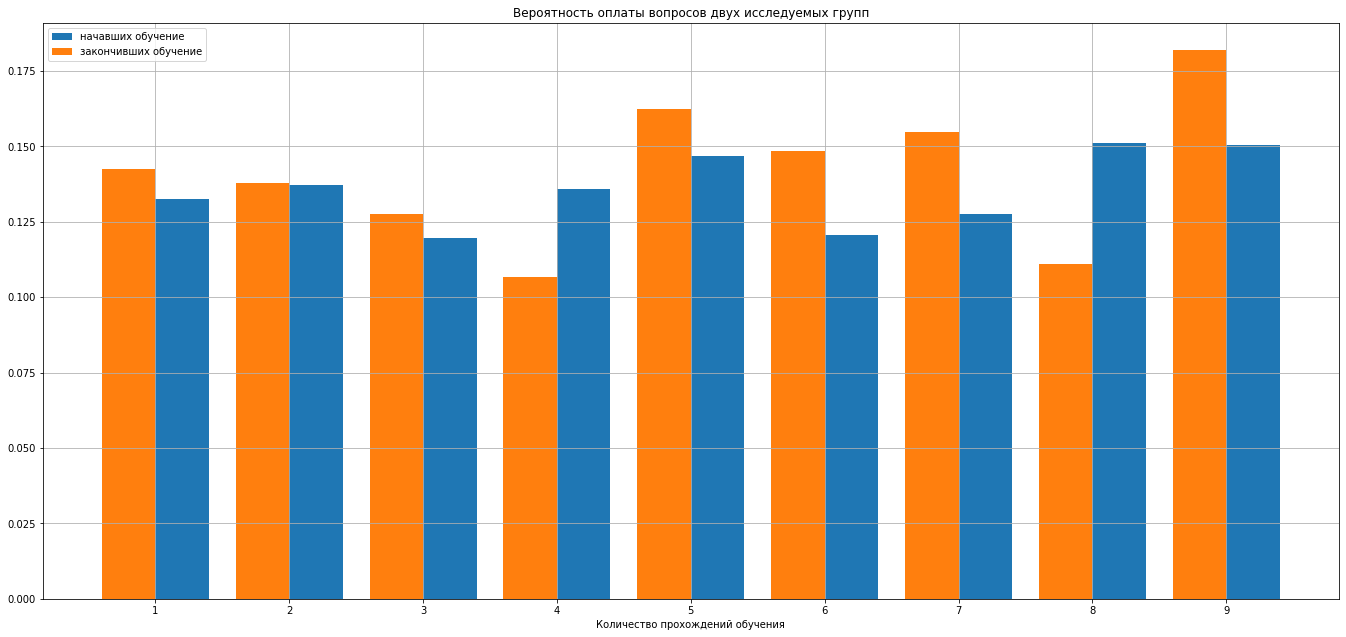

In [ ]:
# просто график ничего особенного
fig = plt.figure()
h = [0.01,0.1,0.15]
axes = fig.add_axes([0, 0, 3, 2])
axes.bar(x = gr_tutorial_df.index, height = gr_tutorial_df['начавших обучение'], 
         width = 0.4, align = 'edge', label = 'начавших обучение',)
axes.bar(x = gr_tutorial_df.index, height = gr_tutorial_df['закончивших обучение'], 
         width = -0.4, align = 'edge', label = 'закончивших обучение',)
axes.legend(loc = 0)
axes.set_title('Вероятность оплаты вопросов двух исследуемых групп')
axes.set_xticks(gr_tutorial_df.index) # исправляю значения по х оси
axes.set_xticklabels(gr_tutorial_df.index)
axes.grid(True)
axes.set_xlabel('Количество прохождений обучения')

### Вывод по второй гипотезе 

Зависимость между вероятностью оплаты вопросов, и количеством обучений, которые начинал или завершал пользователь, не выявлена, также было отмечено другой важные факты. 
Пользователи прошедшие или просто начавшие обучение, делают покупку с сильно большой вероятностью, но следующее знакомство с обучением кроме первого, влияет на покупку скорей случайно. Вывод из этого, что стоит более настойчиво предлагать пользователям эго пройти сразу после регистрации.

### Как часто пользователи начинают обучение после того, как они выбрали уровень сложности?

In [ ]:
# получение списка с путями пользователей
user_path_df = total_events_df.groupby(['user_id'])['event_type'].apply(list).reset_index()

In [ ]:
# всего пользователей 
tot = total_events_df['user_id'].nunique()

In [ ]:
# получение ответа на вопрос чрез универсальный код
def hg(x=0):
    count_tut_aft_lvl_choi = 0
    for i in range(len(user_path_df)):
        if 'level_choice' in user_path_df['event_type'][i]:
            ind = user_path_df['event_type'][i].index('level_choice')
            for g in user_path_df['event_type'][i][ind:]:
                if g == 'tutorial_start':
                    count_tut_aft_lvl_choi += 1
                    if x == 1: # использование функции повторно
                        break
    return count_tut_aft_lvl_choi

#### Числовые выводы по дополнительному вопросу

In [ ]:
# вывод 
print('Число пользователей начавших обучение повторно {} и количество обучений после выбора уровня сложности {}'
      .format(hg(x=1),hg()))
print('Процент пользователей начавших обучение после выбора сложности {:.2%}'.format(hg(x=1)/tot))
print('Среднее число повторений обучения после выбора сложности {:.2f} (для проходивших эго несколько раз)'.format(hg()/hg(x=1)))

Число пользователей начавших обучение повторно 1386 и количество обучений после выбора уровня сложности 2792
Процент пользователей начавших обучение после выбора сложности 6.96%
Среднее число повторений обучения после выбора сложности 2.01 (для проходивших эго несколько раз)


### Вывод по дополнительному вопросу

Около 7 процентов пользователей проходят обучение повторно, и делают в среднем 2 обучения после выбора уровня сложности. Обучение в игре выполняет свою функцию, процент не чересчур большой. А значит, срочных мер по исправлению этой части приложения сейчас не нужно. Но улучшить результат было бы хорошим планом на развитие проекта.